## Runtime Duration of UAT data
Analytics on Runtime data of the UAT reports.

In [139]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display

# prep the environment
data_dir = Path.cwd() / "data"
data_file = data_dir / "uat_data.pkl"

%matplotlib inline


In [140]:
# load the UAT runtime data
if data_file.exists():
    uat_df = pd.read_pickle(data_file)
    print(f"Found {len(uat_df)} records.")
else:
    print(f"Processed data file missing ({data_file}), please run the Data Prep notebook first.")
    exit(-1)

# create time based DataFrame
time_df = uat_df.set_index('StartTime')


Found 621 records.


### Overview


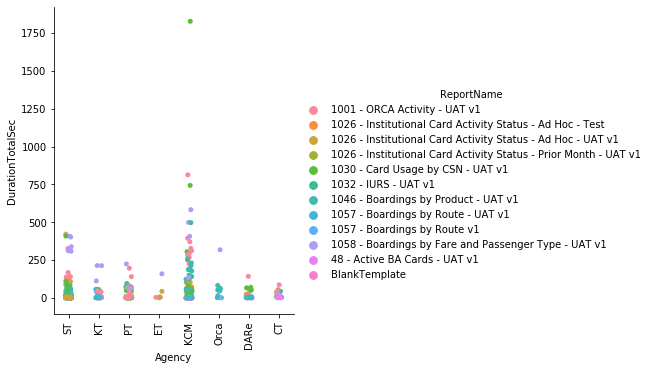

In [141]:
sns.catplot(x='Agency', y='DurationTotalSec', hue='ReportName', data=time_df)
plt.xticks(rotation=90)
plt.show()


### Runtime Split

What proportion of the total runtime is spent Retrieving, Rendering, and Processing the reports.


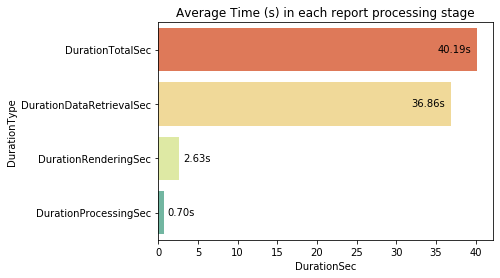

In [142]:
time_cols = ['DurationTotalSec', 'DurationDataRetrievalSec', 'DurationRenderingSec', 'DurationProcessingSec']
time_duration_tidy_df = time_df.melt(['User', 'ResultStatus', 'ReportName'], var_name='DurationType', value_name='DurationSec', value_vars=time_cols)
fig, ax = plt.subplots()    
sns.barplot(x='DurationSec', y='DurationType', data=time_duration_df, palette='Spectral', ci=None)
for i, tcol in enumerate(time_cols):
    val = time_duration_tidy_df[time_duration_tidy_df['DurationType'] == tcol]['DurationSec'].mean()
    if val > 5:
        offset = val - 5
    else:
        offset = val + .5
    ax.text(offset, i + 0.05, f"{val:.2f}s")
plt.title('Average Time (s) in each report processing stage')
plt.show()


### Interactivity

What proportion of the total runtime is spent on Interactive vs Scheduled report.
This will likely only change significantly once we have regular users.


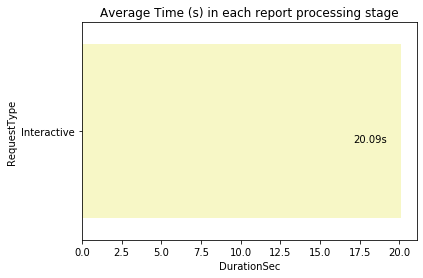

In [143]:
time_cols = ['DurationTotalSec', 'DurationDataRetrievalSec', 'DurationRenderingSec', 'DurationProcessingSec']
time_duration_df = time_df.melt(['RequestType', 'ReportName'], var_name='DurationType', value_name='DurationSec', value_vars=time_cols)
# fig, ax = plt.subplots()    
bplot = sns.barplot(x='DurationSec', y='RequestType', data=time_duration_df, palette='Spectral', ci=None)
for i, tcol in enumerate(time_duration_df['RequestType'].unique()):
    val = time_duration_df[time_duration_df['RequestType'] == tcol]['DurationSec'].mean()
    if val > 5:
        offset = val - 3
    else:
        offset = val + .5
    # ax.text(offset, i + 0.05, f"{val:.2f}s")
    bplot.text(offset, i + 0.05, f"{val:.2f}s")
plt.title('Average Time (s) in each report processing stage')
# bplot.text(0.5, 1, 'Average Time (s) in each report processing stage')
plt.show()

### Stats about runtime

In [150]:
display(uat_df['DurationTotalSec'].describe())

count     621.000000
mean       40.187039
std       114.402888
min         0.000000
25%         0.127000
50%         1.382000
75%        41.875000
max      1827.589000
Name: DurationTotalSec, dtype: float64

Observation:
It's not until the 75th percentile that we get to the sample mean which makes me think that there are several outliers that are dragging the averages.

See the same stats, this time only the queries that had a successful result, and only those from actual UAT users:

In [158]:
live_df = uat_df[uat_df['ResultStatus'] == 'rsSuccess']
live_df = live_df[~live_df['User'].isin(['REPORTAD\\UATUserOrca','UATUserDARe'])]
display(live_df['DurationTotalSec'].describe())

count    560.000000
mean      35.377330
std       90.092157
min        0.000000
25%        0.109500
50%        1.111000
75%       27.755500
max      812.567000
Name: DurationTotalSec, dtype: float64

As you can see, that skews the data more towards normal, although not totally.
And most reports ran in under 1.2s.

In [162]:
from scipy.stats import percentileofscore
num_seconds = 2.0
print(f"A {num_seconds:.1f}s runtime is the {percentileofscore(live_df['DurationTotalSec'], num_seconds):.1f}th percentile")

A 2.0s runtime is the 55.0th percentile


Here's a list of the reports that ran in the 90th percentile:

In [159]:
display(live_df[live_df['DurationTotalSec'] >= live_df['DurationTotalSec'].quantile(.90)])

,Server,ReportPath,User,ExecutionId,RequestType,Format,Parameters,ItemAction,StartTime,StopTime,...,DurationTotalSec,DurationDataRetrievalSec,DurationProcessingSec,DurationRenderingSec,ReportGroup,ReportName,Agency,ParamNumInstitutions,ParamNumMonths,RunClass
134,DEV-2-SSRS\MSSQLSERVER,/5-Kitsap Transit/1058 - Boardings by Fare and...,REPORTAD\UATUserKT,hw5kiw55iyy5jzi12tdmd1y0,Interactive,RPL,ServiceParticipantDimKey=142&SourceParticipant...,Render,2019-07-22 08:34:14.650,2019-07-22 08:37:47.717,...,213.031,212.927,0.078,0.026,5-Kitsap Transit,1058 - Boardings by Fare and Passenger Type - ...,KT,0,1.0,1
850,DEV-2-SSRS\MSSQLSERVER,/6-Pierce Transit/1058 - Boardings by Fare and...,REPORTAD\UATUserPT,u3fpzw454gdf4avdegitbnyn,Interactive,RPL,ServiceParticipantDimKey=143&SourceParticipant...,Render,2019-07-23 13:46:25.890,2019-07-23 13:50:09.600,...,223.669,223.586,0.060,0.023,6-Pierce Transit,1058 - Boardings by Fare and Passenger Type - ...,PT,0,1.0,1
1161,DEV-2-SSRS\MSSQLSERVER,/5-Kitsap Transit/1058 - Boardings by Fare and...,REPORTAD\UATUserKT,l23x4vyohcktwt55ebjsdoa2,Interactive,RPL,ServiceParticipantDimKey=142&SourceParticipant...,Render,2019-07-22 09:15:58.070,2019-07-22 09:19:30.433,...,212.304,212.220,0.064,0.020,5-Kitsap Transit,1058 - Boardings by Fare and Passenger Type - ...,KT,0,1.0,1
1183,DEV-2-SSRS\MSSQLSERVER,/7-Sound Transit/1001 - ORCA Activity - UAT v1,REPORTAD\UATUserST,gmamaeey43y02e55hpneb555,Interactive,RPL,ServiceParticipantDimKey=155&FromDate=6%2F1%2F...,Render,2019-07-22 12:29:39.743,2019-07-22 12:32:00.420,...,140.641,140.591,0.030,0.020,7-Sound Transit,1001 - ORCA Activity - UAT v1,ST,0,1.0,0
1185,DEV-2-SSRS\MSSQLSERVER,/7-Sound Transit/1001 - ORCA Activity - UAT v1,REPORTAD\UATUserST,gmamaeey43y02e55hpneb555,Interactive,RPL,ServiceParticipantDimKey=155&FromDate=6%2F1%2F...,Render,2019-07-22 12:32:01.360,2019-07-22 12:34:13.750,...,132.364,132.331,0.017,0.016,7-Sound Transit,1001 - ORCA Activity - UAT v1,ST,0,1.0,0
1228,DEV-2-SSRS\MSSQLSERVER,/7-Sound Transit/1001 - ORCA Activity - UAT v1,REPORTAD\UATUserST,qjxfiwffx5v5qi554j1sjc45,Interactive,RPL,ServiceParticipantDimKey=155&FromDate=6%2F1%2F...,Render,2019-07-22 09:35:54.433,2019-07-22 09:37:57.907,...,123.435,123.404,0.019,0.012,7-Sound Transit,1001 - ORCA Activity - UAT v1,ST,0,1.0,0
1243,DEV-2-SSRS\MSSQLSERVER,/7-Sound Transit/1058 - Boardings by Fare and ...,REPORTAD\UATUserST,yj1hjq55pdr0qiyfueof4kba,Interactive,RPL,ServiceParticipantDimKey=155&SourceParticipant...,Render,2019-07-22 11:46:37.843,2019-07-22 11:51:45.490,...,307.601,307.537,0.044,0.020,7-Sound Transit,1058 - Boardings by Fare and Passenger Type - ...,ST,0,1.0,1
1319,DEV-2-SSRS\MSSQLSERVER,/6-Pierce Transit/1001 - ORCA Activity - UAT v1,REPORTAD\UATUserPT,anpwjsbjs41hrerlt1t5bm55,Interactive,RPL,ServiceParticipantDimKey=155&FromDate=6%2F1%2F...,Render,2019-07-23 14:16:55.760,2019-07-23 14:20:11.460,...,195.653,195.621,0.019,0.013,6-Pierce Transit,1001 - ORCA Activity - UAT v1,PT,0,1.0,0
1334,DEV-2-SSRS\MSSQLSERVER,/1-ORCA/1001 - ORCA Activity - UAT v1,REPORTAD\UATUserKCM,jbndb155rfcxwm55tr0x3s45,Interactive,RPL,ServiceParticipantDimKey=23&FromDate=6%2F1%2F2...,Render,2019-07-23 14:16:18.130,2019-07-23 14:22:28.403,...,370.229,370.196,0.017,0.016,1-ORCA,1001 - ORCA Activity - UAT v1,KCM,0,1.0,1
1378,DEV-2-SSRS\MSSQLSERVER,/1-ORCA/1058 - Boardings by Fare and Passenger...,REPORTAD\UATUserKCM,tftlrprgyws0vjn42vpt2kuj,Interactive,RPL,ServiceParticipantDimKey=23&SourceParticipantD...,Render,2019-07-23 14:22:37.140,2019-07-23 14:32:19.577,...,582.390,581.924,0.440,0.026,1-ORCA,1058 - Boardings by Fare and Passenger Type - ...,KCM,0,1.0,3


#### Split of runtime duration frequency, by Agency

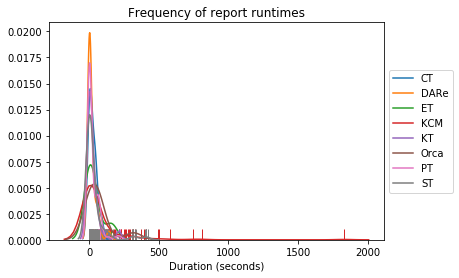

In [144]:
for agency, df in time_df.groupby('Agency'):
    sns.distplot(df['DurationTotalSec'], rug=True, hist=False, label=agency)
plt.xlabel("Duration (seconds)")
plt.title("Frequency of report runtimes")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


#### Number of months in the report vs the number of Institutions in the report

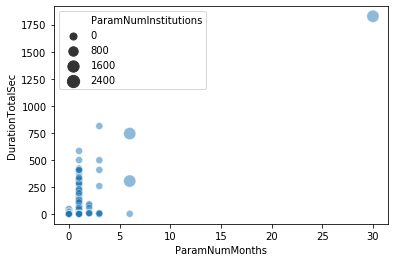

In [148]:
sns.scatterplot(y='DurationTotalSec', x='ParamNumMonths', data=uat_df, alpha=0.5, size='ParamNumInstitutions', sizes=(50,150))
plt.show()

### Some more serious Machine Learning stuff here
An K-Means clustering of runtimes to group them into different "similar" groups for more detailed analysis.

**Note**: due to a limitation of one of the graphs, any cluster containing only 1 point is removed.

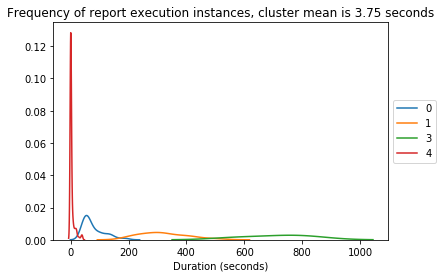

In [145]:
from sklearn.cluster import KMeans
import numpy as np
num_clusters = 5
kmeans = KMeans(n_clusters = num_clusters)
kmeans.fit(np.array(uat_df['DurationTotalSec']).reshape(-1,1))
uat_df['RunClass'] = kmeans.labels_

# print out the clusters
for runclass, df in uat_df.groupby('RunClass'):
    if len(df) < 2:
        continue
    sns.kdeplot(df['DurationTotalSec'], label=runclass)
    plt.xlabel("Duration (seconds)")
    df_mean = kmeans.cluster_centers_[runclass][0]
plt.title(f"Frequency of report execution instances, cluster mean is {df_mean:.2f} seconds")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()



,ClusterMean,Number
2,1827.589000,1
3,712.568000,3
1,320.297700,30
0,78.375187,122
4,3.753834,465


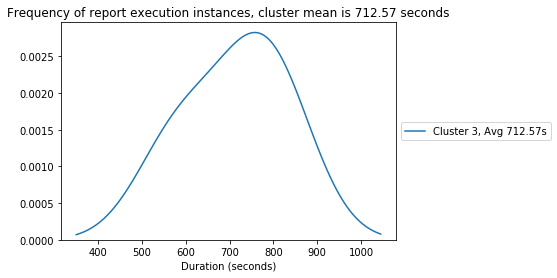

'There are 3 reports execution instances with the mean of 712.57 seconds'

,Agency,ReportPath,ExecutionId,RequestType,Format,Parameters,ItemAction,DurationTotalSec,DurationDataRetrievalSec,DurationProcessingSec,DurationRenderingSec,Source,ResultStatus,ByteCount,RowCount
1378,KCM,/1-ORCA/1058 - Boardings by Fare and Passenger...,tftlrprgyws0vjn42vpt2kuj,Interactive,RPL,ServiceParticipantDimKey=23&SourceParticipantD...,Render,582.390,581.924,0.440,0.026,Live,rsSuccess,45241,3466
1605,KCM,/4-King County Metro/1030 - Card Usage by CSN ...,vlkhto45zzz5t155c1byj1fu,Interactive,RPL,AgencyDimKey=5&InstitutionDimKey=17&Institutio...,Render,742.747,577.327,153.590,11.830,Live,rsSuccess,7559676,657343
2985,KCM,/1-ORCA/1001 - ORCA Activity - UAT v1,ktl1og45tj4v4j3kpf1fvi3n,Interactive,RPL,ServiceParticipantDimKey=23&FromDate=1%2F1%2F2...,Render,812.567,812.514,0.033,0.020,Live,rsSuccess,20522,263


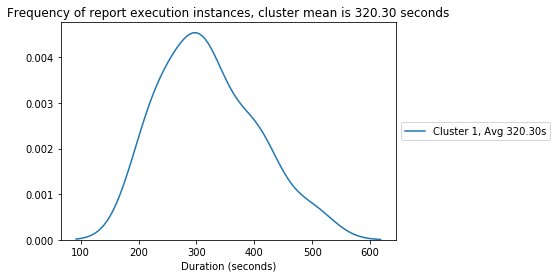

'There are 30 reports execution instances with the mean of 320.30 seconds'

,Agency,ReportPath,ExecutionId,RequestType,Format,Parameters,ItemAction,DurationTotalSec,DurationDataRetrievalSec,DurationProcessingSec,DurationRenderingSec,Source,ResultStatus,ByteCount,RowCount
134,KT,/5-Kitsap Transit/1058 - Boardings by Fare and...,hw5kiw55iyy5jzi12tdmd1y0,Interactive,RPL,ServiceParticipantDimKey=142&SourceParticipant...,Render,213.031,212.927,0.078,0.026,Live,rsSuccess,42652,983
850,PT,/6-Pierce Transit/1058 - Boardings by Fare and...,u3fpzw454gdf4avdegitbnyn,Interactive,RPL,ServiceParticipantDimKey=143&SourceParticipant...,Render,223.669,223.586,0.060,0.023,Live,rsSuccess,40119,651
1161,KT,/5-Kitsap Transit/1058 - Boardings by Fare and...,l23x4vyohcktwt55ebjsdoa2,Interactive,RPL,ServiceParticipantDimKey=142&SourceParticipant...,Render,212.304,212.220,0.064,0.020,Live,rsSuccess,42652,983
1243,ST,/7-Sound Transit/1058 - Boardings by Fare and ...,yj1hjq55pdr0qiyfueof4kba,Interactive,RPL,ServiceParticipantDimKey=155&SourceParticipant...,Render,307.601,307.537,0.044,0.020,Live,rsSuccess,41505,419
1334,KCM,/1-ORCA/1001 - ORCA Activity - UAT v1,jbndb155rfcxwm55tr0x3s45,Interactive,RPL,ServiceParticipantDimKey=23&FromDate=6%2F1%2F2...,Render,370.229,370.196,0.017,0.016,Live,rsSuccess,20512,275
1384,KCM,/4-King County Metro/1001 - ORCA Activity - UA...,s1qjpi45joxhbvnvaaqkobmc,Interactive,RPL,ServiceParticipantDimKey=23&FromDate=6%2F1%2F2...,Render,393.547,393.498,0.031,0.018,Live,rsSuccess,20546,275
1508,Orca,/7-Sound Transit/1058 - Boardings by Fare and ...,wmigqg45bzk2auafwccgmm55,Interactive,RPL,ServiceParticipantDimKey=155&SourceParticipant...,Render,317.330,317.273,0.036,0.021,Live,rsSuccess,41507,419
1597,ST,/7-Sound Transit/1001 - ORCA Activity - UAT v1,ubk5i321mt3att45a4vu1r45,Interactive,RPL,ServiceParticipantDimKey=155&FromDate=6%2F1%2F...,Render,420.857,420.827,0.018,0.012,Live,rsSuccess,20470,281
1603,ST,/7-Sound Transit/1001 - ORCA Activity - UAT v1,legk1ieldxm3ujfhubgeyf55,Interactive,RPL,ServiceParticipantDimKey=155&FromDate=6%2F1%2F...,Render,325.552,325.493,0.026,0.033,Live,rsSuccess,20470,281
1620,KCM,/1-ORCA/1001 - ORCA Activity - UAT v1,zru4xlft4iepz5f20ivoif45,Interactive,RPL,ServiceParticipantDimKey=23&FromDate=6%2F1%2F2...,Render,225.901,225.875,0.026,0.000,Live,rsProcessingAborted,0,179


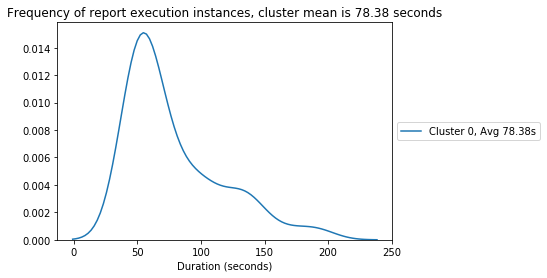

'There are 122 reports execution instances with the mean of 78.38 seconds'

,Agency,ReportPath,ExecutionId,RequestType,Format,Parameters,ItemAction,DurationTotalSec,DurationDataRetrievalSec,DurationProcessingSec,DurationRenderingSec,Source,ResultStatus,ByteCount,RowCount
131,KT,/5-Kitsap Transit/1058 - Boardings by Fare and...,ctojssuw3duq4tqwg1ilq4fo,Interactive,RPL,ServiceParticipantDimKey=142&SourceParticipant...,Render,111.089,111.056,0.033,0.000,Live,rsProcessingAborted,0,358
563,ET,/3-Everett Transit/1058 - Boardings by Fare an...,luncjselmppgtruu1brbin55,Interactive,RPL,ServiceParticipantDimKey=13&SourceParticipantD...,Render,158.391,158.367,0.024,0.000,Live,rsProcessingAborted,0,358
573,KCM,/1-ORCA/1026 - Institutional Card Activity Sta...,xc23or2vlw5eyxrdp3a1sluv,Interactive,RPL,AgencyDimKey=5&InstitutionDimKey=17&BranchDimK...,Render,42.961,41.495,1.343,0.123,Live,rsSuccess,22457,15486
583,KCM,/1-ORCA/1030 - Card Usage by CSN - UAT v1,2ngizy2a4b50qs3weudnncvv,Interactive,RPL,AgencyDimKey=5&InstitutionDimKey=17&FromDate=6...,Render,48.464,46.241,1.093,1.130,Live,rsSuccess,7416643,12023
586,KCM,/1-ORCA/1030 - Card Usage by CSN - UAT v1,2ngizy2a4b50qs3weudnncvv,Interactive,RPL,AgencyDimKey=5&InstitutionDimKey=19&FromDate=6...,Render,55.459,54.619,0.350,0.490,Live,rsSuccess,3166057,6428
600,ET,/3-Everett Transit/1026 - Institutional Card A...,quh0eh45bmg30g55gxjveomm,Interactive,RPL,AgencyDimKey=4&InstitutionDimKey=1843&BranchDi...,Render,42.424,42.236,0.168,0.020,Live,rsSuccess,15915,7953
603,KCM,/1-ORCA/1030 - Card Usage by CSN - UAT v1,2ssas2qudy0mhbjldzpncqbr,Interactive,RPL,AgencyDimKey=5&InstitutionDimKey=17&FromDate=6...,Render,55.243,53.270,0.852,1.121,Live,rsSuccess,7416643,12023
610,KCM,/1-ORCA/1030 - Card Usage by CSN - UAT v1,zwztwcispkskmtbdsclqry3j,Interactive,RPL,AgencyDimKey=5&InstitutionDimKey=187&FromDate=...,Render,50.750,42.639,3.729,4.382,Live,rsSuccess,25324644,38153
643,PT,/6-Pierce Transit/1026 - Institutional Card Ac...,k4xkmg45libfss55tj1a5k45,Interactive,RPL,AgencyDimKey=6&InstitutionDimKey=3724&BranchDi...,Render,76.414,76.293,0.104,0.017,Live,rsSuccess,15929,5827
653,PT,/6-Pierce Transit/1030 - Card Usage by CSN - U...,ntja2zj2djpajc453rbffc55,Interactive,RPL,AgencyDimKey=7&InstitutionDimKey=18&FromDate=5...,Render,89.663,89.594,0.042,0.027,Live,rsSuccess,42882,2308


In [146]:
# for each cluster that's not the smallest cluster, and filtering out clusters that only have 1 entry
cluster_df = pd.DataFrame({'ClusterMean': kmeans.cluster_centers_[:,0], 'Number': pd.DataFrame(kmeans.labels_)[0].value_counts(sort=False)})
cluster_df.sort_values(by='ClusterMean', ascending=False, inplace=True)
display(cluster_df)

cluster_df.drop(cluster_df['ClusterMean'].idxmin(), inplace=True)
cluster_df = cluster_df[cluster_df['Number'] > 1]

for cluster in cluster_df.index:
    df = uat_df[uat_df['RunClass'] == cluster]
    df_mean = kmeans.cluster_centers_[cluster][0]
    sns.kdeplot(df['DurationTotalSec'], label=f"Cluster {cluster}, Avg {df_mean:.2f}s")
    plt.xlabel("Duration (seconds)")
    plt.title(f"Frequency of report execution instances, cluster mean is {df_mean:.2f} seconds")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    display(f"There are {len(df)} reports execution instances with the mean of {df_mean:.2f} seconds")
    display(df[['Agency', 'ReportPath', 'ExecutionId', 'RequestType', 'Format', 'Parameters', 'ItemAction', 
                'DurationTotalSec', 'DurationDataRetrievalSec', 'DurationProcessingSec', 'DurationRenderingSec',
                'Source', 'ResultStatus', 'ByteCount', 'RowCount']])